# E-commerce Data — Exploratory Data Analysis

This notebook performs a professional EDA on the e-commerce star-schema files found in this folder. It will:

- Load dimension and fact CSV files
- Validate keys and basic referential integrity between fact and dimension tables
- Produce cleaned summary tables
- Generate polished, light-themed visualizations with a professional color palette
- Save summary visuals and an EDA report

Files imported automatically from the folder:
- `dim_customer.csv`, `dim_product.csv`, `dim_date.csv`, `dim_region.csv`, `dim_channel.csv`, `dim_campaign.csv`, `dim_payment.csv`, `fact_sales.csv`

In [34]:
# 1) Import libraries and set plotting theme
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Light theme and professional palette
sns.set_theme(style="whitegrid")
# Professional palette: use seaborn's deep palette (good for presentations)
professional_palette = sns.color_palette("deep")
sns.set_palette(professional_palette)

# Display options
pd.options.display.max_columns = None
pd.options.display.float_format = '{:,.2f}'.format

print("Libraries loaded. Theme: light, palette: professional (deep)")

Libraries loaded. Theme: light, palette: professional (deep)


In [35]:
# 2) Load all CSVs from this folder automatically
base = Path('.').resolve()
files = list(base.glob('*.csv'))
print('Found CSV files:', [f.name for f in files])

# Helper to read with inference
def read_csv(fp):
    try:
        return pd.read_csv(fp)
    except Exception as e:
        return pd.read_csv(fp, encoding='latin1')

# Load expected tables into a dict
tables = {}
expected = ['dim_customer','dim_product','dim_date','dim_region','dim_channel','dim_campaign','dim_payment','fact_sales','dataset_summary']
for f in files:
    name = f.stem
    if name in expected:
        tables[name] = read_csv(f)
    else:
        # still load unknowns for inspection
        tables[name] = read_csv(f)

# Show loaded table names and row counts
for k, v in tables.items():
    print(f"- {k}: {v.shape[0]} rows × {v.shape[1]} cols")

Found CSV files: ['dataset_summary.csv', 'dim_campaign.csv', 'dim_campaign_with_unknown.csv', 'dim_channel.csv', 'dim_customer.csv', 'dim_date.csv', 'dim_payment.csv', 'dim_product.csv', 'dim_region.csv', 'fact_sales.csv', 'fact_sales_remapped_campaigns.csv']
- dataset_summary: 1 rows × 4 cols
- dim_campaign: 20 rows × 5 cols
- dim_campaign_with_unknown: 21 rows × 5 cols
- dim_channel: 3 rows × 2 cols
- dim_customer: 5000 rows × 6 cols
- dim_date: 1366 rows × 9 cols
- dim_payment: 4 rows × 2 cols
- dim_product: 200 rows × 8 cols
- dim_region: 6 rows × 4 cols
- fact_sales: 40000 rows × 22 cols
- fact_sales_remapped_campaigns: 40000 rows × 22 cols
- dataset_summary: 1 rows × 4 cols
- dim_campaign: 20 rows × 5 cols
- dim_campaign_with_unknown: 21 rows × 5 cols
- dim_channel: 3 rows × 2 cols
- dim_customer: 5000 rows × 6 cols
- dim_date: 1366 rows × 9 cols
- dim_payment: 4 rows × 2 cols
- dim_product: 200 rows × 8 cols
- dim_region: 6 rows × 4 cols
- fact_sales: 40000 rows × 22 cols
- fact

## 3) Quick table inspection and key checks
We'll show the first rows from each table and detect candidate primary keys and foreign keys in the fact table.

In [36]:
# Show sample rows and candidate keys
for name in ['dim_customer','dim_product','dim_date','dim_region','dim_channel','dim_campaign','dim_payment','fact_sales']:
    if name in tables:
        print('\n' + '='*80)
        print(f"Table: {name} — shape: {tables[name].shape}")
        display(tables[name].head())

# Candidate keys: check uniqueness of id-like columns in dims
key_checks = {}
for dim in ['dim_customer','dim_product','dim_date','dim_region','dim_channel','dim_campaign','dim_payment']:
    if dim in tables:
        df_dim = tables[dim]
        # choose the first column that ends with '_id' or 'id' or 'code'
        candidate = None
        for c in df_dim.columns:
            if c.lower().endswith('_id') or c.lower().endswith('id') or 'code' in c.lower():
                candidate = c
                break
        if candidate:
            unique = df_dim[candidate].is_unique
            key_checks[dim] = (candidate, unique)
        else:
            key_checks[dim] = (None, False)

print('\nCandidate key checks:')
for k, v in key_checks.items():
    print(f"- {k}: candidate={v[0]}, unique={v[1]}")


Table: dim_customer — shape: (5000, 6)


,customer_id,customer_name,email,join_date,loyalty_tier,gender
0,1,Ahmed Ali,user1@example.com,2024-03-25,Silver,M
1,2,Ahmed Hussain,user2@example.com,2023-04-16,Bronze,F
2,3,Hassan Shah,user3@example.com,2024-06-23,Bronze,M
3,4,Sara Ali,user4@example.com,2024-05-03,Silver,M
4,5,Hina Hussain,user5@example.com,2022-05-08,Bronze,M



Table: dim_product — shape: (200, 8)


,product_id,sku,product_name,category,brand,list_price,cost,is_active
0,1,SKU-1001,Home & Kitchen Product 1,Home & Kitchen,Brand_29,475.60,329.49,1
1,2,SKU-1002,Home & Kitchen Product 2,Home & Kitchen,Brand_21,54.49,31.81,1
2,3,SKU-1003,Health & Beauty Product 3,Health & Beauty,Brand_12,15.19,11.97,0
3,4,SKU-1004,Electronics Product 4,Electronics,Brand_26,496.14,321.00,1
4,5,SKU-1005,Home & Kitchen Product 5,Home & Kitchen,Brand_10,149.16,96.17,1



Table: dim_date — shape: (1366, 9)


,date_key,date,year,quarter,month,month_name,day,day_of_week,is_weekend
0,20220101,2022-01-01,2022,1,1,Jan,1,6,True
1,20220102,2022-01-02,2022,1,1,Jan,2,7,True
2,20220103,2022-01-03,2022,1,1,Jan,3,1,False
3,20220104,2022-01-04,2022,1,1,Jan,4,2,False
4,20220105,2022-01-05,2022,1,1,Jan,5,3,False



Table: dim_region — shape: (6, 4)


,region_id,country,state,city
0,1,Pakistan,Punjab,Lahore
1,2,Pakistan,Sindh,Karachi
2,3,Pakistan,Khyber Pakhtunkhwa,Peshawar
3,4,Pakistan,Punjab,Gujranwala
4,5,UAE,Dubai,Dubai



Table: dim_channel — shape: (3, 2)


,channel_id,channel
0,1,Website
1,2,Mobile App
2,3,Marketplace



Table: dim_campaign — shape: (20, 5)


,campaign_id,campaign_name,channel,start_date,end_date
0,1,Campaign_1,Search,2022-08-19,2023-02-12
1,2,Campaign_2,Affiliate,2022-01-04,2023-07-09
2,3,Campaign_3,Affiliate,2022-09-07,2023-05-24
3,4,Campaign_4,Email,2022-11-29,2023-06-07
4,5,Campaign_5,Email,2022-11-21,2023-09-27



Table: dim_payment — shape: (4, 2)


,payment_id,payment_method
0,1,Credit Card
1,2,Cash on Delivery
2,3,PayPal
3,4,Wallet



Table: fact_sales — shape: (40000, 22)


,order_id,order_line_id,order_date,date_key,product_id,customer_id,region_id,channel_id,payment_id,campaign_id,quantity,unit_price,discount_pct,shipping_amount,tax_pct,line_revenue,line_cost,gross_profit,is_return,refund_amount,delivery_days,order_status
0,218977,218977-0,2022-10-17,20221017,120,3211,3,1,3,7,2,129.46,0.10,30,0.10,263.03,138.02,125.01,0,0.00,1,Shipped
1,220987,220987-1,2023-11-24,20231124,119,3409,1,2,3,10,3,472.66,0.05,0,0.09,"1,347.08","1,049.10",297.98,0,0.00,3,Shipped
2,252763,252763-2,2022-04-12,20220412,90,735,5,1,4,0,2,197.86,0.00,0,0.12,395.72,205.40,190.32,1,273.97,1,Refunded
3,237429,237429-3,2023-07-15,20230715,131,3281,4,1,1,0,4,80.19,0.00,50,0.14,370.76,156.12,214.64,0,0.00,7,Processing
4,277601,277601-4,2024-12-08,20241208,11,4230,2,2,4,6,4,159.30,0.05,0,0.13,605.34,387.44,217.90,0,0.00,2,Delivered



Candidate key checks:
- dim_customer: candidate=customer_id, unique=True
- dim_product: candidate=product_id, unique=True
- dim_date: candidate=None, unique=False
- dim_region: candidate=region_id, unique=True
- dim_channel: candidate=channel_id, unique=True
- dim_campaign: candidate=campaign_id, unique=True
- dim_payment: candidate=payment_id, unique=True


In [37]:
# 4) Referential integrity checks: ensure foreign keys in fact_sales match dimension keys
fact = tables['fact_sales']

print('Fact columns:', list(fact.columns))

# Map of expected FK columns to dimension tables
fk_map = {
    'customer_id': 'dim_customer',
    'product_id': 'dim_product',
    'date_key': 'dim_date',
    'region_id': 'dim_region',
    'channel_id': 'dim_channel',
    'campaign_id': 'dim_campaign',
    'payment_id': 'dim_payment'
}

integrity_issues = {}
for fk, dim in fk_map.items():
    if fk in fact.columns and dim in tables:
        dim_keys = set(tables[dim].iloc[:,0])  # assume first col is key
        missing = fact[~fact[fk].isin(dim_keys)][fk].nunique()
        missing_rows = fact[~fact[fk].isin(dim_keys)].shape[0]
        integrity_issues[fk] = (missing_rows, missing)
    else:
        integrity_issues[fk] = (None, None)

print('\nReferential integrity summary (foreign_key: missing_rows, unique_missing_values):')
for k, v in integrity_issues.items():
    print(f"- {k}: {v}")

# Show a sample of unmatched rows for first failing key
for k, v in integrity_issues.items():
    if v[0] and v[0] > 0:
        print(f"\nSample unmatched rows for {k}:")
        display(fact[~fact[k].isin(set(tables[fk_map[k]].iloc[:,0]))].head())
        break

Fact columns: ['order_id', 'order_line_id', 'order_date', 'date_key', 'product_id', 'customer_id', 'region_id', 'channel_id', 'payment_id', 'campaign_id', 'quantity', 'unit_price', 'discount_pct', 'shipping_amount', 'tax_pct', 'line_revenue', 'line_cost', 'gross_profit', 'is_return', 'refund_amount', 'delivery_days', 'order_status']

Referential integrity summary (foreign_key: missing_rows, unique_missing_values):
- customer_id: (0, 0)
- product_id: (0, 0)
- date_key: (0, 0)
- region_id: (0, 0)
- channel_id: (0, 0)
- campaign_id: (8118, 1)
- payment_id: (0, 0)

Sample unmatched rows for campaign_id:


,order_id,order_line_id,order_date,date_key,product_id,customer_id,region_id,channel_id,payment_id,campaign_id,quantity,unit_price,discount_pct,shipping_amount,tax_pct,line_revenue,line_cost,gross_profit,is_return,refund_amount,delivery_days,order_status
2,252763,252763-2,2022-04-12,20220412,90,735,5,1,4,0,2,197.86,0.00,0,0.12,395.72,205.40,190.32,1,273.97,1,Refunded
3,237429,237429-3,2023-07-15,20230715,131,3281,4,1,1,0,4,80.19,0.00,50,0.14,370.76,156.12,214.64,0,0.00,7,Processing
6,252137,252137-6,2024-07-15,20240715,118,4803,2,1,1,0,2,269.50,0.20,0,0.13,431.20,377.28,53.92,0,0.00,4,Delivered
7,205909,205909-7,2024-01-28,20240128,109,1393,2,1,3,0,1,200.29,0.00,30,0.11,230.29,94.67,135.62,0,0.00,1,Delivered
9,278099,278099-9,2022-10-16,20221016,184,1974,6,1,3,0,1,228.85,0.05,50,0.13,267.41,122.10,145.31,0,0.00,2,Delivered


In [38]:
# 4.5) Cleaning step: remap unmatched campaign_id values to 'Unknown' and save backups
# This ensures the notebook is reproducible: adds 'Unknown' to dim_campaign if missing and remaps fact rows
import numpy as np

# Work on copies in the tables dict for reproducibility
fact = tables['fact_sales']
dim_campaign = tables.get('dim_campaign').copy() if 'dim_campaign' in tables else None

# Normalize campaign_id types to string to avoid mismatch due to types
if 'campaign_id' in fact.columns:
    fact['campaign_id'] = fact['campaign_id'].fillna('Unknown').astype(str)
else:
    print('No campaign_id in fact_sales; skipping campaign cleaning')

if dim_campaign is not None:
    # Ensure dim keys are strings too
    key_col = dim_campaign.columns[0]
    dim_campaign[key_col] = dim_campaign[key_col].fillna('Unknown').astype(str)
    dim_keys = set(dim_campaign[key_col].unique())
    # Find missing campaign ids in the fact table (excluding 'Unknown')
    missing_ids = set(fact.loc[~fact['campaign_id'].isin(dim_keys), 'campaign_id'].unique())
    missing_ids.discard('Unknown')
    print('Missing campaign ids detected (sample up to 10):', list(missing_ids)[:10])

    # Show sample rows for the first missing id (if any)
    if missing_ids:
        first_missing = list(missing_ids)[0]
        print(f"Sample rows for missing campaign_id=\'{first_missing}\':")
        display(fact[fact['campaign_id'] == first_missing].head())

    # Add 'Unknown' row to dim_campaign if not present
    if 'Unknown' not in dim_campaign[key_col].values:
        new_row = {c: (('Unknown' if 'name' in c.lower() or 'campaign' in c.lower() else '')) for c in dim_campaign.columns}
        new_row[key_col] = 'Unknown'
        dim_campaign = pd.concat([dim_campaign, pd.DataFrame([new_row])], ignore_index=True)
        backup_path = Path('dim_campaign_with_unknown.csv')
        dim_campaign.to_csv(backup_path, index=False)
        print('Added Unknown campaign to dim_campaign and saved backup to', backup_path)
    else:
        print('dim_campaign already contains Unknown campaign id')

    # Remap any missing ids in fact to 'Unknown' and save remapped fact for traceability
    if missing_ids:
        mask = fact['campaign_id'].isin(missing_ids)
        remapped_count = mask.sum()
        fact.loc[mask, 'campaign_id'] = 'Unknown'
        print(f"Remapped {remapped_count} fact rows from {len(missing_ids)} missing campaign_id(s) to 'Unknown'.")
        remapped_path = Path('fact_sales_remapped_campaigns.csv')
        fact.to_csv(remapped_path, index=False)
        print('Saved remapped fact to', remapped_path)
    else:
        print('No remapping was necessary for campaign_id')

    # Update the tables dict so downstream cells use cleaned tables
    tables['dim_campaign'] = dim_campaign
    tables['fact_sales'] = fact
else:
    print('dim_campaign table not found; no changes made')

Missing campaign ids detected (sample up to 10): ['0']
Sample rows for missing campaign_id='0':


,order_id,order_line_id,order_date,date_key,product_id,customer_id,region_id,channel_id,payment_id,campaign_id,quantity,unit_price,discount_pct,shipping_amount,tax_pct,line_revenue,line_cost,gross_profit,is_return,refund_amount,delivery_days,order_status
2,252763,252763-2,2022-04-12,20220412,90,735,5,1,4,0,2,197.86,0.00,0,0.12,395.72,205.40,190.32,1,273.97,1,Refunded
3,237429,237429-3,2023-07-15,20230715,131,3281,4,1,1,0,4,80.19,0.00,50,0.14,370.76,156.12,214.64,0,0.00,7,Processing
6,252137,252137-6,2024-07-15,20240715,118,4803,2,1,1,0,2,269.50,0.20,0,0.13,431.20,377.28,53.92,0,0.00,4,Delivered
7,205909,205909-7,2024-01-28,20240128,109,1393,2,1,3,0,1,200.29,0.00,30,0.11,230.29,94.67,135.62,0,0.00,1,Delivered
9,278099,278099-9,2022-10-16,20221016,184,1974,6,1,3,0,1,228.85,0.05,50,0.13,267.41,122.10,145.31,0,0.00,2,Delivered


Added Unknown campaign to dim_campaign and saved backup to dim_campaign_with_unknown.csv
Remapped 8118 fact rows from 1 missing campaign_id(s) to 'Unknown'.
Saved remapped fact to fact_sales_remapped_campaigns.csv
Saved remapped fact to fact_sales_remapped_campaigns.csv


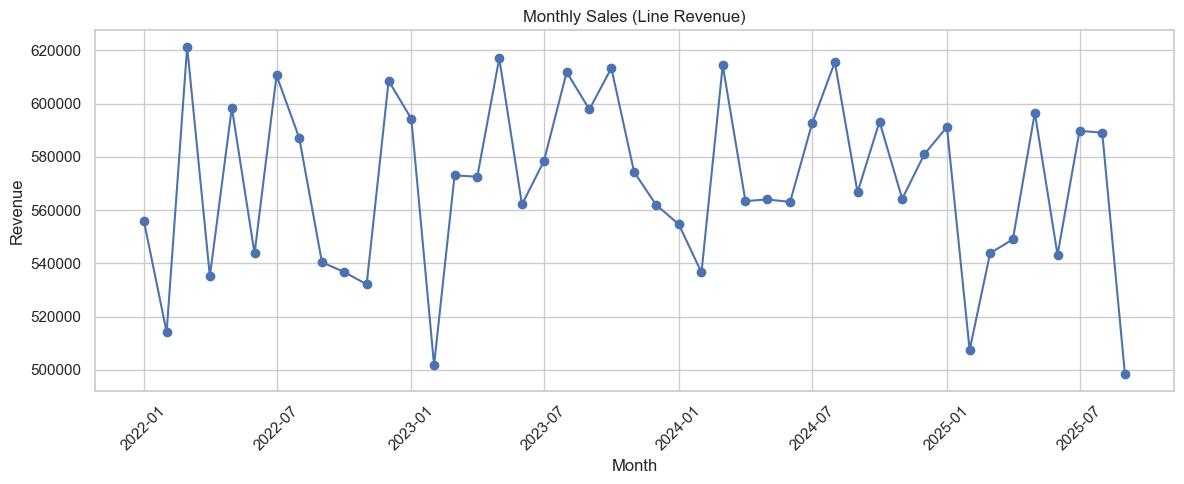

Saved: ecom_eda_plots\sales_monthly.png


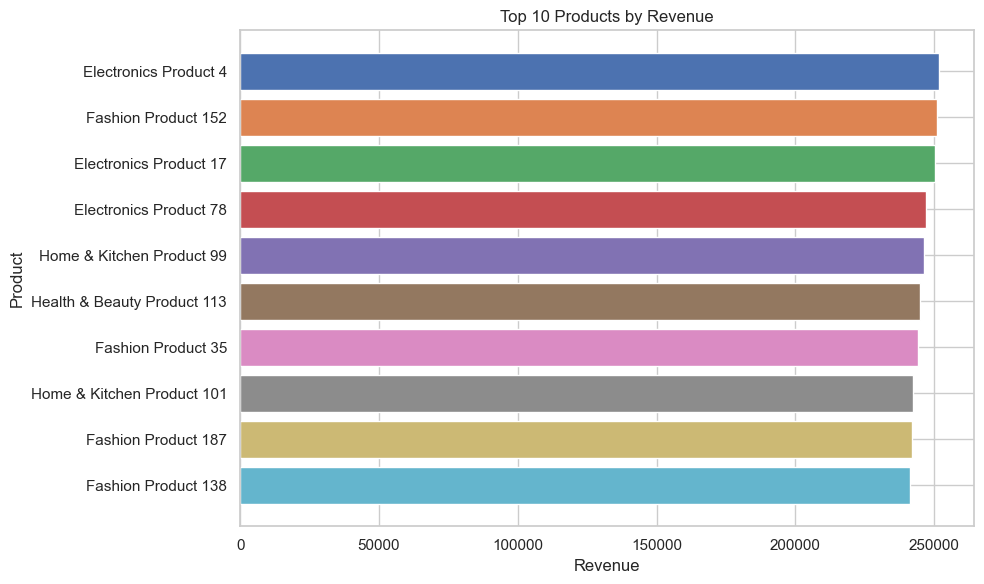

Saved: ecom_eda_plots\top_products.png


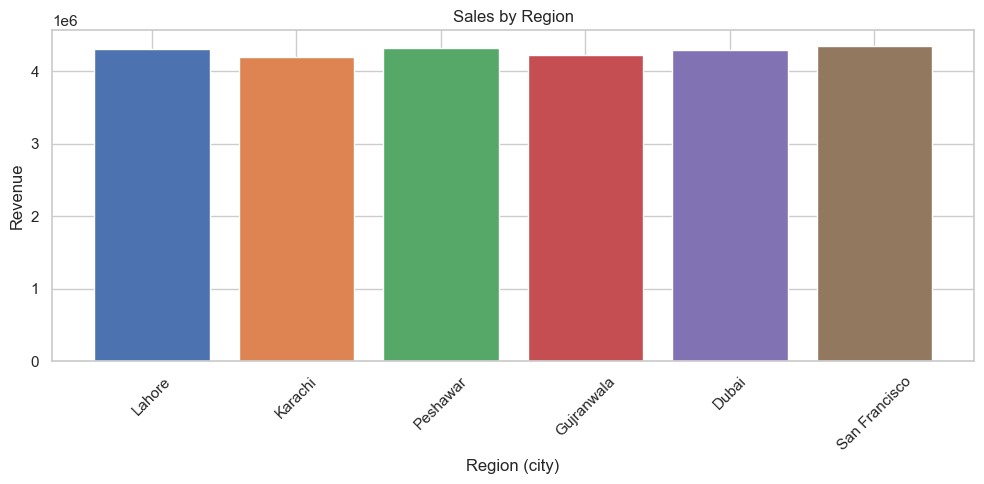

Saved: ecom_eda_plots\sales_by_region.png


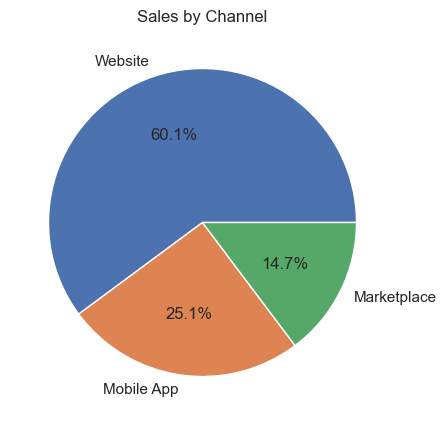

Saved: ecom_eda_plots\sales_by_channel.png


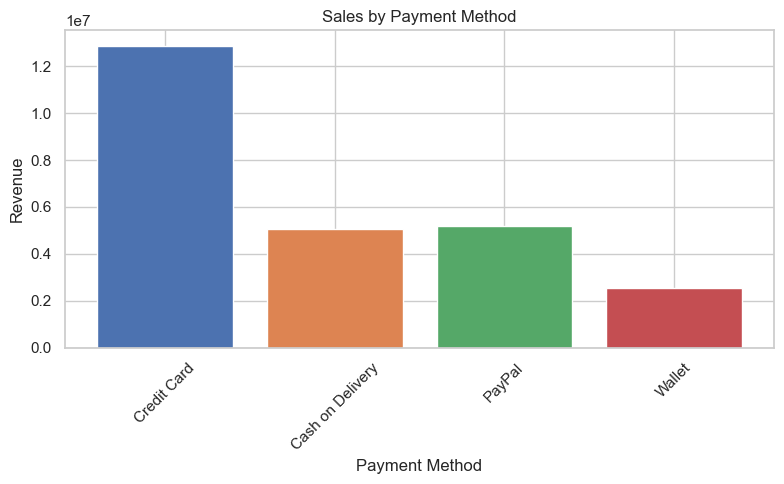

Saved: ecom_eda_plots\sales_by_payment.png


In [39]:
# 5) Aggregations and visualizations — create output folder
output_dir = Path('ecom_eda_plots')
output_dir.mkdir(exist_ok=True)

# Ensure order_date parsed
fact['order_date'] = pd.to_datetime(fact['order_date'])

# Sales over time (monthly)
fact['month'] = fact['order_date'].dt.to_period('M').dt.to_timestamp()
sales_month = fact.groupby('month')['line_revenue'].sum().reset_index()

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(sales_month['month'], sales_month['line_revenue'], marker='o')
ax.set_title('Monthly Sales (Line Revenue)')
ax.set_ylabel('Revenue')
ax.set_xlabel('Month')
plt.xticks(rotation=45)
plt.tight_layout()
fig_path = output_dir / 'sales_monthly.png'
fig.savefig(fig_path, dpi=120)
plt.show()
print(f"Saved: {fig_path}")

# Top 10 products by revenue
prod_sales = fact.groupby('product_id')['line_revenue'].sum().nlargest(10).reset_index()
# map product names
prod_lookup = tables['dim_product'].set_index('product_id')['product_name']
prod_sales['product_name'] = prod_sales['product_id'].map(prod_lookup)

# Use explicit color list sized to the data to avoid seaborn palette warnings
colors = sns.color_palette('deep', n_colors=len(prod_sales))
fig, ax = plt.subplots(figsize=(10,6))
# horizontal bar with explicit colors (reverse order to show largest at top)
ax.barh(prod_sales['product_name'][::-1], prod_sales['line_revenue'][::-1], color=colors[::-1])
ax.set_title('Top 10 Products by Revenue')
ax.set_xlabel('Revenue')
ax.set_ylabel('Product')
plt.tight_layout()
fig_path = output_dir / 'top_products.png'
fig.savefig(fig_path, dpi=120)
plt.show()
print(f"Saved: {fig_path}")

# Sales by region
region_sales = fact.groupby('region_id')['line_revenue'].sum().reset_index()
region_lookup = tables['dim_region'].set_index('region_id')['city']
region_sales['region'] = region_sales['region_id'].map(region_lookup)

fig, ax = plt.subplots(figsize=(10,5))
colors = sns.color_palette('deep', n_colors=len(region_sales))
ax.bar(region_sales['region'], region_sales['line_revenue'], color=colors)
ax.set_title('Sales by Region')
ax.set_ylabel('Revenue')
ax.set_xlabel('Region (city)')
plt.xticks(rotation=45)
plt.tight_layout()
fig_path = output_dir / 'sales_by_region.png'
fig.savefig(fig_path, dpi=120)
plt.show()
print(f"Saved: {fig_path}")

# Sales by channel
channel_sales = fact.groupby('channel_id')['line_revenue'].sum().reset_index()
channel_lookup = tables['dim_channel'].set_index('channel_id')['channel']
channel_sales['channel'] = channel_sales['channel_id'].map(channel_lookup)

fig, ax = plt.subplots(figsize=(8,5))
colors = sns.color_palette('deep', n_colors=len(channel_sales))
ax.pie(channel_sales['line_revenue'], labels=channel_sales['channel'], autopct='%1.1f%%', colors=colors)
ax.set_title('Sales by Channel')
fig_path = output_dir / 'sales_by_channel.png'
fig.savefig(fig_path, dpi=120)
plt.show()
print(f"Saved: {fig_path}")

# Payment methods distribution
payment_sales = fact.groupby('payment_id')['line_revenue'].sum().reset_index()
payment_lookup = tables['dim_payment'].set_index('payment_id')['payment_method']
payment_sales['payment_method'] = payment_sales['payment_id'].map(payment_lookup)

fig, ax = plt.subplots(figsize=(8,5))
colors = sns.color_palette('deep', n_colors=len(payment_sales))
ax.bar(payment_sales['payment_method'], payment_sales['line_revenue'], color=colors)
ax.set_title('Sales by Payment Method')
ax.set_ylabel('Revenue')
ax.set_xlabel('Payment Method')
plt.xticks(rotation=45)
plt.tight_layout()
fig_path = output_dir / 'sales_by_payment.png'
fig.savefig(fig_path, dpi=120)
plt.show()
print(f"Saved: {fig_path}")

## Analytical Framework: Descriptive / Diagnostic / Predictive / Prescriptive

This section runs a concise set of analyses using key numeric fields such as `line_revenue`, `gross_profit`, and `discount_pct` (or `discount_&pct` variants).

- Descriptive: summary statistics and distributions
- Diagnostic: correlations and drivers (how discount affects margin/revenue)
- Predictive: a simple regression model to predict `line_revenue` (requires scikit-learn)
- Prescriptive: simple discount guidance derived from historical margins

All generated charts are saved to the `ecom_eda_plots/` folder for easy review.

Descriptive columns used: ['line_revenue', 'gross_profit', 'discount_pct']


,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
line_revenue,"40,000.00",641.52,477.91,6.10,30.38,71.87,256.18,507.90,935.27,"1,602.52","1,920.64","2,093.80"
gross_profit,"40,000.00",256.27,211.38,0.08,7.74,29.80,95.78,195.18,359.94,698.32,936.69,"1,210.72"
discount_pct,"40,000.00",0.04,0.06,0.00,0.00,0.00,0.00,0.00,0.05,0.15,0.20,0.20


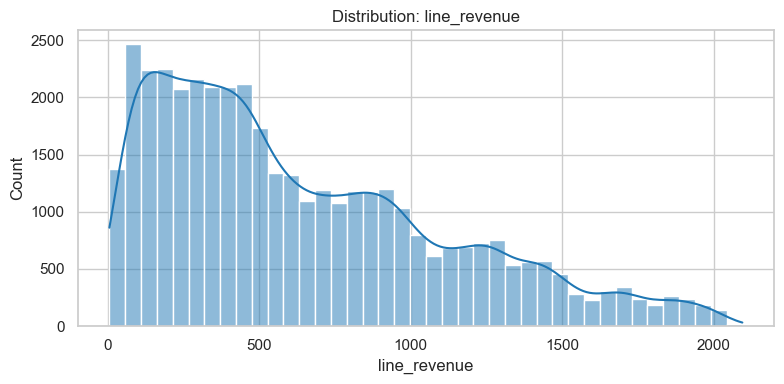

Saved: ecom_eda_plots\distr_line_revenue.png


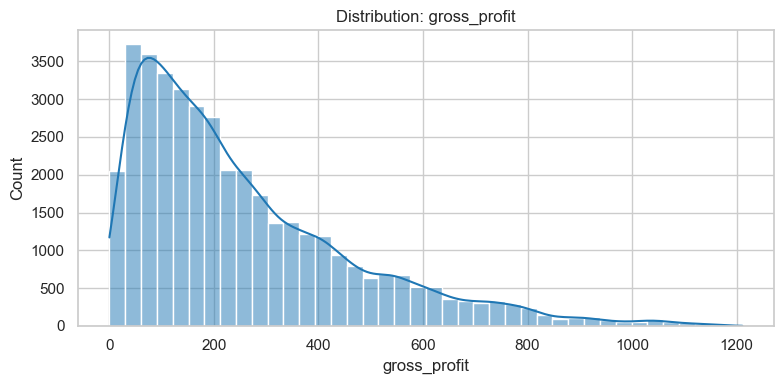

Saved: ecom_eda_plots\distr_gross_profit.png


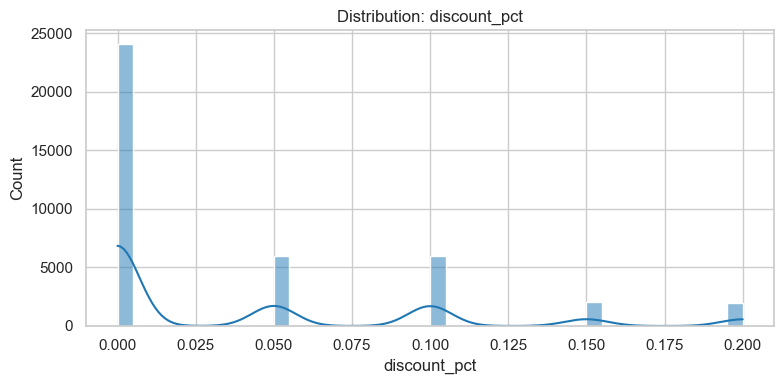

Saved: ecom_eda_plots\distr_discount_pct.png


In [40]:
# Descriptive Analysis: summary stats and distributions
cols = []
for c in ['line_revenue','gross_profit','discount_pct','discount_pct','discount_pct']:
    if c in fact.columns and c not in cols:
        cols.append(c)

if not cols:
    # fallbacks for common alternative names
    for alt in ['line_revenue','line_revenue_amount','gross_profit','gross_profit_amount','discount','discount_pct','discount_pct']:
        if alt in fact.columns and alt not in cols:
            cols.append(alt)

print('Descriptive columns used:', cols)

# Summary table
desc = fact[cols].describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99]).T
display(desc)

# Histograms and KDEs for numeric columns
for c in cols:
    fig, ax = plt.subplots(figsize=(8,4))
    sns.histplot(fact[c].dropna(), kde=True, ax=ax, bins=40, color='tab:blue')
    ax.set_title(f'Distribution: {c}')
    plt.tight_layout()
    p = output_dir / f'distr_{c}.png'
    fig.savefig(p, dpi=120, bbox_inches='tight')
    plt.show()
    print('Saved:', p)

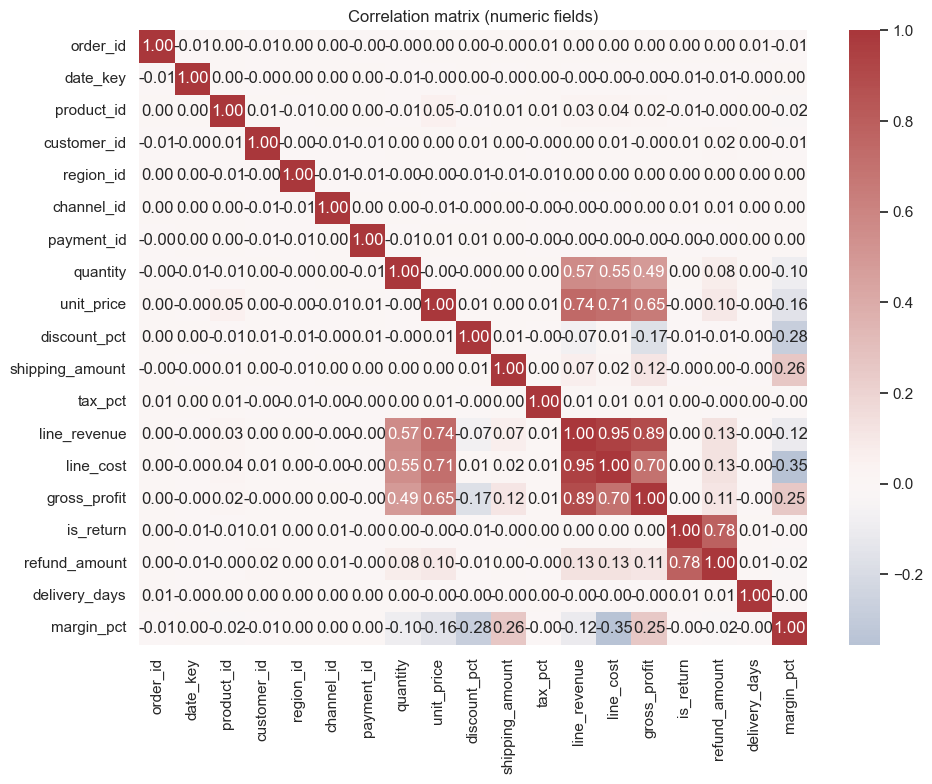

Saved: ecom_eda_plots\correlation_matrix.png


C:\Users\Abid.Maqsood.GROUPAMS\AppData\Local\Temp\ipykernel_21600\2199991742.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = tmp.groupby('disc_bin').agg({'line_revenue':'sum','margin_pct':'mean','disc_bin':'count'}).rename(columns={'disc_bin':'count'})


,disc_bin,line_revenue,margin_pct,count
0,"(-0.0002, 0.02]","16,018,136.32",0.43,24033
1,"(0.02, 0.04]",0.00,NaN,0
2,"(0.04, 0.06]","3,806,985.05",0.41,6010
3,"(0.06, 0.08]",0.00,NaN,0
4,"(0.08, 0.1]","3,550,430.08",0.38,5941
5,"(0.1, 0.12]",0.00,NaN,0
6,"(0.12, 0.14]",0.00,NaN,0
7,"(0.14, 0.16]","1,164,945.54",0.34,2020
8,"(0.16, 0.18]",0.00,NaN,0
9,"(0.18, 0.2]","1,120,175.25",0.30,1996


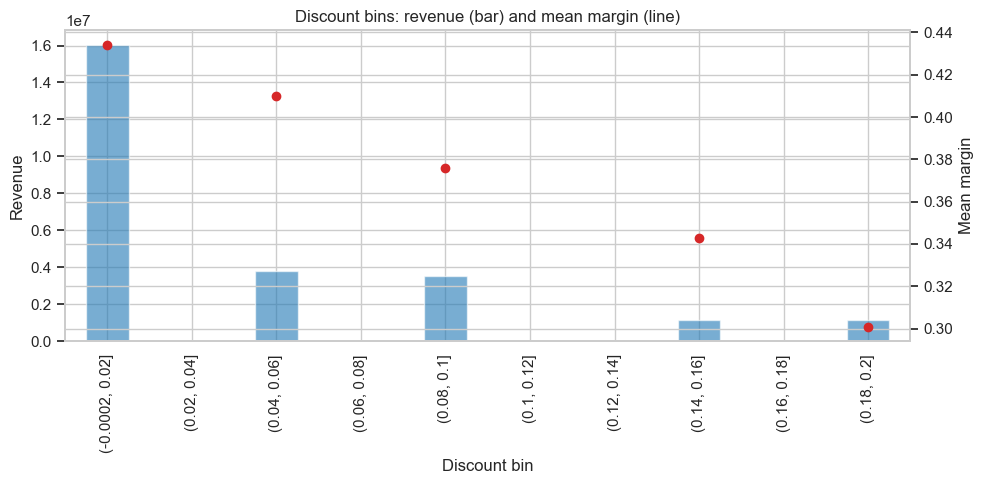

Saved: ecom_eda_plots\discount_margin_diag.png


In [41]:
# Diagnostic Analysis: correlation matrix and discount vs margin diagnostics
numeric = fact.select_dtypes(include=['number']).copy()
# ensure gross profit and discount exist; create margin if possible
if 'gross_profit' in numeric.columns and 'line_revenue' in numeric.columns:
    numeric['margin_pct'] = numeric['gross_profit'] / numeric['line_revenue']

corr = numeric.corr(method='pearson')
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='vlag', center=0, ax=ax)
ax.set_title('Correlation matrix (numeric fields)')
plt.tight_layout()
p = output_dir / 'correlation_matrix.png'
fig.savefig(p, dpi=120, bbox_inches='tight')
plt.show()
print('Saved:', p)

# Discount vs margin: bin discounts and compute mean margin and revenue
disc_col = None
for c in ['discount_pct','discount','discount_percent']:
    if c in fact.columns:
        disc_col = c
        break

if disc_col is not None and 'margin_pct' in numeric.columns:
    tmp = fact[[disc_col,'line_revenue']].copy()
    tmp['margin_pct'] = fact['gross_profit'] / fact['line_revenue']
    tmp = tmp.dropna()
    tmp['disc_bin'] = pd.cut(tmp[disc_col], bins=10)
    agg = tmp.groupby('disc_bin').agg({'line_revenue':'sum','margin_pct':'mean','disc_bin':'count'}).rename(columns={'disc_bin':'count'})
    display(agg.reset_index())
    fig, ax = plt.subplots(figsize=(10,5))
    ax2 = ax.twinx()
    agg['margin_pct'].plot(ax=ax2, color='tab:red', marker='o', label='mean_margin')
    agg['line_revenue'].plot(ax=ax, color='tab:blue', kind='bar', alpha=0.6, label='revenue')
    ax.set_xlabel('Discount bin')
    ax.set_ylabel('Revenue')
    ax2.set_ylabel('Mean margin')
    ax.set_title('Discount bins: revenue (bar) and mean margin (line)')
    plt.tight_layout()
    p = output_dir / 'discount_margin_diag.png'
    fig.savefig(p, dpi=120, bbox_inches='tight')
    plt.show()
    print('Saved:', p)
else:
    print('Discount column or margin not available; skipping discount diagnostics')

Using features: ['quantity', 'unit_price', 'discount_pct', 'gross_profit']

📌 Predictive Model Summary
Features used: ['quantity', 'unit_price', 'discount_pct', 'gross_profit']
RMSE: 129.34
R² Score: 0.9256

Feature Coefficients:


quantity       164.86
unit_price       1.61
gross_profit     0.85
discount_pct   -98.34
dtype: float64

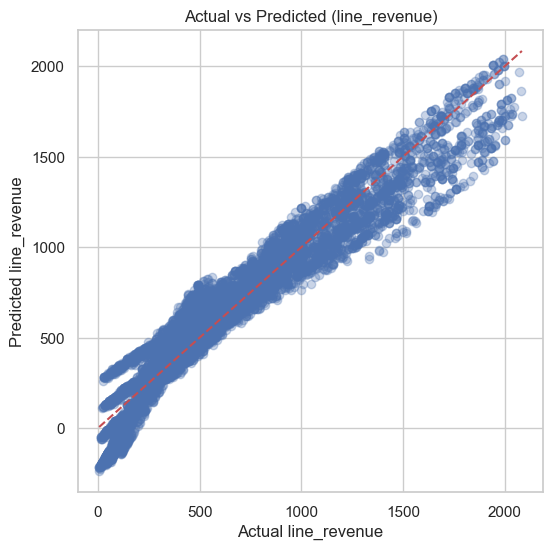

Saved plot to: ecom_eda_plots\predict_actual_vs_pred.png


In [42]:
# Predictive Analysis: Simple model to predict line_revenue 
# using quantity, unit_price, discount, gross_profit (if available)

# Ensure scikit-learn is installed
!pip install scikit-learn --quiet

try:
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_squared_error, r2_score
    import numpy as np

    SKLEARN_AVAILABLE = True
except ImportError:
    print("scikit-learn not available; install scikit-learn to run predictive analysis")
    SKLEARN_AVAILABLE = False

if SKLEARN_AVAILABLE:

    # -------- FEATURE SELECTION --------
    candidate_features = ['quantity', 'unit_price', 'discount_pct', 'discount', 'gross_profit']
    features = [col for col in candidate_features if col in fact.columns]

    if not features:
        print("No suitable numeric features found for prediction. Please select features manually.")
    else:
        print("Using features:", features)

        # -------- FEATURE + TARGET PREPARATION --------
        X = fact[features].astype(float).fillna(0)
        if 'line_revenue' not in fact.columns:
            raise ValueError("Target column 'line_revenue' does not exist in dataset.")
        y = fact['line_revenue'].astype(float).fillna(0)

        # -------- TRAIN/TEST SPLIT --------
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        # -------- MODEL TRAINING --------
        model = LinearRegression()
        model.fit(X_train, y_train)

        # -------- PREDICTIONS --------
        preds = model.predict(X_test)

        # -------- METRICS --------
        rmse = np.sqrt(mean_squared_error(y_test, preds))  # ✅ Works on all versions
        r2 = r2_score(y_test, preds)

        print(f"\n📌 Predictive Model Summary")
        print(f"Features used: {features}")
        print(f"RMSE: {rmse:,.2f}")
        print(f"R² Score: {r2:.4f}\n")

        # -------- COEFFICIENTS --------
        coeffs = pd.Series(model.coef_, index=features).sort_values(ascending=False)
        print("Feature Coefficients:")
        display(coeffs)

        # -------- SCATTER PLOT --------
        import matplotlib.pyplot as plt
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.scatter(y_test, preds, alpha=0.3)
        ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
        ax.set_xlabel("Actual line_revenue")
        ax.set_ylabel("Predicted line_revenue")
        ax.set_title("Actual vs Predicted (line_revenue)")

        p = output_dir / "predict_actual_vs_pred.png"
        fig.savefig(p, dpi=120, bbox_inches="tight")
        plt.show()

        print("Saved plot to:", p)


In [43]:
# Prescriptive Analysis: simple rule-based guidance for discounting
# Goal: find discount bins where mean margin remains acceptable, and recommend a max discount
threshold_margin = 0.10  # recommend that mean margin stays above 10% unless otherwise specified
if 'margin_pct' not in fact.columns and 'gross_profit' in fact.columns and 'line_revenue' in fact.columns:
    fact['margin_pct'] = fact['gross_profit'] / fact['line_revenue']

if disc_col is not None and 'margin_pct' in fact.columns:
    tmp = fact[[disc_col,'margin_pct','line_revenue']].dropna()
    tmp['disc_bin'] = pd.cut(tmp[disc_col], bins=20)
    agg = tmp.groupby('disc_bin').agg(mean_margin=('margin_pct','mean'), revenue=('line_revenue','sum'), count=('margin_pct','count')).reset_index()
    display(agg.head(20))
    # find max discount bin where mean_margin >= threshold_margin
    good = agg[agg['mean_margin'] >= threshold_margin]
    if not good.empty:
        # recommend the upper edge of the highest bin that meets the threshold
        last_good = good.iloc[-1]['disc_bin']
        rec = last_good.right
        print(f'Recommendation: consider setting a discount cap near {rec:.2f} (based on historical mean margin >= {threshold_margin:.2%})')
    else:
        print('No discount bin meets the margin threshold; consider raising prices or reducing discounts')
else:
    print('Cannot compute prescriptive guidance: missing discount or margin columns')

C:\Users\Abid.Maqsood.GROUPAMS\AppData\Local\Temp\ipykernel_21600\2108827685.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = tmp.groupby('disc_bin').agg(mean_margin=('margin_pct','mean'), revenue=('line_revenue','sum'), count=('margin_pct','count')).reset_index()


,disc_bin,mean_margin,revenue,count
0,"(-0.0002, 0.01]",0.43,"16,018,136.32",24033
1,"(0.01, 0.02]",NaN,0.00,0
2,"(0.02, 0.03]",NaN,0.00,0
3,"(0.03, 0.04]",NaN,0.00,0
4,"(0.04, 0.05]",0.41,"3,806,985.05",6010
5,"(0.05, 0.06]",NaN,0.00,0
6,"(0.06, 0.07]",NaN,0.00,0
7,"(0.07, 0.08]",NaN,0.00,0
8,"(0.08, 0.09]",NaN,0.00,0
9,"(0.09, 0.1]",0.38,"3,550,430.08",5941


Recommendation: consider setting a discount cap near 0.20 (based on historical mean margin >= 10.00%)
